# Credit Risk Prediction


You have received data from LendingClub. LendingClub is/was a peer-to-peer platform for small loans which originated in the early days of facebook. It grew into a multi-billion dollar company with over 15 billion in loans provided. However, since the Covid pandemic and a merger with an other bank it has discontinued it's peer-to-peer lending. For further info see https://en.wikipedia.org/wiki/LendingClub

LendingClub made it's data available to the public, in an anonymised way obviously. We have data for a number of years of all loans which are approved on the platform. So we know which loans are completed (Loan status = Fully Paid), which loans are in progress (Current) and which loans are not payed back (Charged Off). We do not know why LendingClub stoped it's activities but let's assume that it is because there were too many loans not being payed. Our job is to build a model which is able to predict loans which which might not be repayed. Our employees can then contact these people to look for solutions or maybe not grant the loan from the start. 





## What you should deliver

A clean and documented notebook in which you do:
- exploratory data analysis (try to already eliminate a lot of features)
- preprocessing (at the end of your pre-pro phase you should have minimally 30 features and maximally 60)
- model building (optionally including feature selection)
- performance evaluation (ROC, AUC, PR)

At the end of your notebook, after you have done all your modelling and preprocessing you have to predict unknown loans (the test set). I will quantify your performance on this unknown data.

## What to look out for

Some variables are only measured when the loan is 'going on' e.g. date of next payment, last payment amount, days since last missed payment, how much of the loan is already paid, etc. These variables obviously need to be removed as we are building a model which delivers a prediction at the startpoint of the loan. 

In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

float #Anders krijg je een warming `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.

float

In [39]:
selection = ["id","acc_now_delinq", "addr_state", "annual_inc", "application_type", "disbursement_method", 
"earliest_cr_line", "emp_length", "emp_title", "fico_range_high", "fico_range_low", 
"grade", "home_ownership", "inq_fi", "installment", "int_rate", "verification_status", 
"loan_amnt", "funded_amnt_inv", "loan_status", "mort_acc", "num_bc_sats", "num_bc_tl", 
"num_il_tl", "num_rev_accts", "num_sats", "open_acc", "percent_bc_gt_75", "policy_code", 
"pub_rec", "pub_rec_bankruptcies", "revol_bal", "sub_grade", "tax_liens", 
"term", "total_cu_tl"]
data = pd.read_csv("LendingClub_data.csv", usecols=selection, index_col="id")
data

C:\Users\dylan\AppData\Local\Temp\ipykernel_28952\546693106.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("LendingClub_data.csv", usecols=selection, index_col="id")


,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,mort_acc,num_bc_sats,num_bc_tl,num_il_tl,num_rev_accts,num_sats,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,disbursement_method
id,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,...,1.0,2.0,5.0,3.0,9.0,7.0,0.0,0.0,0.0,Cash
68355089,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,...,4.0,13.0,17.0,6.0,27.0,22.0,7.7,0.0,0.0,Cash
68341763,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,...,5.0,2.0,4.0,6.0,7.0,6.0,50.0,0.0,0.0,Cash
66310712,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,...,1.0,8.0,10.0,2.0,13.0,13.0,0.0,0.0,0.0,Cash
68476807,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,...,6.0,5.0,9.0,10.0,19.0,12.0,60.0,0.0,0.0,Cash
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88985880,40000.0,40000.0,60 months,10.49,859.56,B,B3,Vice President,9 years,MORTGAGE,...,3.0,2.0,15.0,9.0,23.0,5.0,50.0,0.0,0.0,Cash
88224441,24000.0,24000.0,60 months,14.49,564.56,C,C4,Program Manager,6 years,RENT,...,2.0,5.0,15.0,4.0,24.0,10.0,40.0,1.0,0.0,Cash
88215728,14000.0,14000.0,60 months,14.49,329.33,C,C4,Customer Service Technician,10+ years,MORTGAGE,...,1.0,4.0,12.0,3.0,17.0,8.0,50.0,0.0,0.0,Cash


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2193435 entries, 68407277 to Total amount funded in policy code 2: 521953170
Data columns (total 35 columns):
 #   Column                Dtype  
---  ------                -----  
 0   loan_amnt             float64
 1   funded_amnt_inv       float64
 2   term                  object 
 3   int_rate              float64
 4   installment           float64
 5   grade                 object 
 6   sub_grade             object 
 7   emp_title             object 
 8   emp_length            object 
 9   home_ownership        object 
 10  annual_inc            float64
 11  verification_status   object 
 12  loan_status           object 
 13  addr_state            object 
 14  earliest_cr_line      object 
 15  fico_range_low        float64
 16  fico_range_high       float64
 17  open_acc              float64
 18  pub_rec               float64
 19  revol_bal             float64
 20  policy_code           float64
 21  application_type      object 
 22  

In [41]:
## Cleaning
def cleanDF(data):
    print("Cleaning empty Loans...")
    ### remove empty loans
    data.dropna(axis=0, subset=["loan_amnt"], inplace=True)

    print("Creating flag to check if loan is fully funded...")
    ## funded_amnt_inv
    data["full_funded"] = 0
    data.loc[data["funded_amnt_inv"] == data["loan_amnt"], "full_funded"] = 1

    data.drop(["funded_amnt_inv"], axis=1, inplace=True)

    print("Determining if short term loan or long term...")
    ### Create ST (short term) or LT (long term)
    data["short_term_loan"] = 0 #Default is long term loan (60 months)
    data.loc[data["term"] == " 36 months", "short_term_loan"] = 1 #If 36 months, make Short term loan

    data.drop(["term"], axis=1, inplace=True)

    print("Determining interest rate category...")
    ### int_rate
    data["int_rate_cat"] = 1 #<= 5
    data.loc[ (data["int_rate"] > 5) & (data["int_rate"] <= 10), "int_rate_cat"] = 2 # 6 - 10
    data.loc[ (data["int_rate"] > 10) & (data["int_rate"] <= 15), "int_rate_cat"] = 3 # 11 - 15
    data.loc[ (data["int_rate"] > 15) & (data["int_rate"] <= 20), "int_rate_cat"] = 4 # 16 - 20
    data.loc[ data["int_rate"] > 20, "int_rate_cat"] = 5 #> 20

    data.drop(["int_rate"], axis=1, inplace=True)

    print("Determining small, medium or large installments...")
    ### Installment
    #Small, medium or large installment?
    data["installment_cat"] = "SI"
    data.loc[ data["installment"] <= 350, "installment_cat"] = "SI" #small installment
    data.loc[ (data["installment"] > 350) & (data["installment"] <= 1000), "installment_cat"] = "MI" #medium
    data.loc[ data["installment"] > 1000 , "installment_cat"] = "LI" #large

    data = data.join(pd.get_dummies(data["installment_cat"]))

    data.drop(["installment"], axis=1, inplace=True)
    data.drop(["installment_cat"], axis=1, inplace=True)

    print("Cleaning (sub)grade...")
    ### grade & subgrade
    data["grade_num"] = "0"
    for grade in data["grade"].unique(): #Turns char-grade into numeric
        #A = 1, B = 2, ...
        data.loc[data["grade"].str.contains(grade), "grade_num"] = str(ord(grade) - 64)

    data["grade_num"] = data["grade_num"] + data["sub_grade"].str[1:] #Add subgrade too
    data["grade_num"] = data["grade_num"].astype("int64")
    data["grade_num"].dtype

    data.drop(["grade"], axis=1, inplace=True)
    data.drop(["sub_grade"], axis=1, inplace=True)

    print("Determining long or short term employment...")
    ### emp_length
    data["emp_ST"] = 1 #Default is working not so long (Short term (= ST))
    data.loc[data["emp_length"] == "10+ years", "emp_ST"] = 0 #If more than 10, make long term

    data.drop(["emp_length"], axis=1, inplace=True)

    print("Determining if person owns mortgage...")
    ### home_ownership
    data["home_ownership"].unique()
    data["mortgage"] = 0

    data.loc[data["home_ownership"] == "MORTGAGE", "mortgage"] = 1

    data.drop(["home_ownership"], axis=1, inplace=True)

    print("Determining financial class..")
    ### annual_inc 
    # https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system

    data["income_class"] = "class_P" #poor <= 32048
    data.loc[ (data["annual_inc"] > 32048) & (data["annual_inc"] <= 53413), "income_class"] = "class_LMC" #lower-middle class
    data.loc[ (data["annual_inc"] > 53413) & (data["annual_inc"] <= 106827), "income_class"] = "class_MC" #middle class
    data.loc[ (data["annual_inc"] > 106827) & (data["annual_inc"] <= 373894), "income_class"] = "class_UMC" #upper-middle class
    data.loc[ (data["annual_inc"] > 373894) , "income_class"] = "class_R" #rich

    data = data.join(pd.get_dummies(data["income_class"]))
    data.drop(["income_class"], axis=1, inplace=True)

    print("Determining flag for checked annual income...")
    ### verification_status
    data["income_verified"] = 0
    data.loc[data["verification_status"].str.contains("Verified"), "income_verified"] = 1

    data.drop(["verification_status"], axis=1, inplace=True)

    print("Cleaning loan status / labels...")
    ### loan_status
    #### Zijn de labels, alleen "Fully Paid" & "Charged Off" behouden
    for status in data["loan_status"].unique():
        if status == "Fully Paid":
            continue
        elif status == "Charged Off":
            continue
        else:
            data.drop(data[data["loan_status"] == status].index, inplace = True)
            print("Deleted", status)

    data["fully_paid"] = 1       
    data.loc[data["loan_status"] == "Charged Off", "fully_paid"] = 0


    data.drop(["loan_status"], axis=1, inplace=True)

    print("Changing states to categories...")
    ### addr_state
    # PA = 1, SD = 2, GA = 3, MN = 4, SC = 5, RI = 6, NC = 7, CA = 8, VA = 9, AZ = 10, 
    # IN = 11, MD = 12, NY = 13, TX = 14, KS = 15, NM = 16, AL = 17, WA = 18, OH = 19, 
    # LA = 20, IL = 21, FL = 22, CO = 23, MI = 24, DC = 25, MA = 26, WI = 27, HI = 28, 
    # NJ = 29, DE = 30, TN = 31, NH = 32, NE = 33, OR = 34, CT = 35, AR = 36, NV = 37, 
    # WV = 38, MT = 39, WY = 40, OK = 41, KY = 42, MO = 43, VT = 44, MS = 45, UT = 46, 
    # ND = 47, ME = 48, AK = 49, ID = 50, IA = 51, 

    count = 0
    data["addr_numb"] = 0
    for state in data["addr_state"].unique():
        data.loc[(data["addr_state"] == state), "addr_numb"] = count
        count += 1

    data.drop(["addr_state"], axis=1, inplace=True)

    print("Determining year of earliest credit line...")
    ### earliest_cr_line
    data["earliest_cr_line"] = data["earliest_cr_line"].str[4:] #Just take year, not months (dec-2001 -> 2001)

    print("Determining credit score category...")
    ### fico_range_low & fico_range_high
    #### Neem middelste getal in deze range, behandel dit als de score van die persoon, maak beoordeling based on american system
    #### https://www.experian.com/blogs/ask-experian/credit-education/score-basics/what-is-a-good-credit-score/

    data["credit_score"] = "fico_P" #Poor
    data["fico_range_high"] = data["fico_range_high"] - 2
    data.loc[(data["fico_range_high"] >= 580) & (data["fico_range_high"] <= 669), "credit_score"] = "fico_F" #fair
    data.loc[(data["fico_range_high"] >= 670) & (data["fico_range_high"] <= 739), "credit_score"] = "fico_G" #good
    data.loc[(data["fico_range_high"] >= 740) & (data["fico_range_high"] <= 799), "credit_score"] = "fico_VG" #very good
    data.loc[(data["fico_range_high"] >= 800) & (data["fico_range_high"] <= 850), "credit_score"] = "fico_E" #exceptional

    data = data.join(pd.get_dummies(data["credit_score"]))
    data.drop(["credit_score"], axis=1, inplace=True)
    data.drop(["fico_range_low"], axis=1, inplace=True)
    data.drop(["fico_range_high"], axis=1, inplace=True)

    print("Determining if there are derogatory public records...")
    ### pub_rec
    #### “Derogatory” is seen as negative to lenders, and can include late payments, collection accounts, bankruptcy, charge-offs and other negative marks.
    data["has_derpub"] = 0
    data.loc[(data["pub_rec"] > 0), "has_derpub"] = 1

    data.drop(["pub_rec"], axis=1, inplace=True)

    print("Calculating amount of credit cards...")
    ### revol_bal
    #### Amount on credit cards, 
    data["revol_bal"] = (data["revol_bal"] / data["annual_inc"]) * 100 #Revolving balance % of annual income

    data["revol_bal_cat"] = "credit_NR"
    data.loc[data["revol_bal"] < 30, "revol_bal_cat"] = "credit_NR" #No Risk
    data.loc[(data["revol_bal"] >= 30) & (data["revol_bal"] <= 50), "revol_bal_cat"] = "credit_SR" #Small Risk
    data.loc[data["revol_bal"] > 50, "revol_bal_cat"] = "credit_HR" #High Risk

    data = data.join(pd.get_dummies(data["revol_bal_cat"]))
    data.drop(["revol_bal"], axis=1, inplace=True)
    data.drop(["revol_bal_cat"], axis=1, inplace=True)
    data.drop(["annual_inc"], axis=1, inplace=True)

    print("Dropping policy code...")
    ### policy_code
    #### is it publicly available this product (y = 1, n = 0)
    #### All 1 so you can drop it
    data.drop(["policy_code"], axis=1, inplace=True)

    print("Deleting joint applications...")
    ### application_type
    #### Joint mag eruit
    data.drop(data[data["application_type"] == "Joint App"].index, inplace = True)
    data.drop(["application_type"], axis=1, inplace=True)

    print("Determining if there were some delinquent payments...")
    ### acc_now_delinq
    #### Heeft de aanvrager ooit achterstallige betalingen gehad die niet binnen de 30 dagen zijn betaald?
    data["delinq_past"] = 0

    data.loc[data["acc_now_delinq"] > 0, "delinq_past"] = 1

    data.drop(["acc_now_delinq"], axis=1, inplace=True)

    print("Amount of hard inquiries, putting them in categories...")
    ### inq_fi
    #### A hard inquiry, also known as a hard pull, is a request to check your credit when you apply to borrow money through a credit card or loan. Each hard inquiry will lower your credit scores by a few points.
    data["inq_fi_cat"] = 0

    data.loc[(data["inq_fi"] > 0) & (data["inq_fi"] < 5), "inq_fi_cat"] = 1 # 1 - 4
    data.loc[(data["inq_fi"] >= 5) & (data["inq_fi"] < 10), "inq_fi_cat"] = 2 # 5 - 9
    data.loc[data["inq_fi"] >= 10, "inq_fi_cat"] = 3 # 10(+)

    data.drop(["inq_fi"], axis=1, inplace=True)

    print("Calculating trade finances...")
    ### total_cu_tl
    #### In simple terms, trade finance is when an exporter requires an importer to prepay for goods shipped. The importer naturally wants to reduce risk by asking the exporter to document that the goods have been shipped as proof.
    data["past_fin_trade_cat"] = 0

    data.loc[(data["total_cu_tl"] > 0) & (data["total_cu_tl"] < 5), "past_fin_trade_cat"] = 1 # 1 - 4
    data.loc[(data["total_cu_tl"] >= 5) & (data["total_cu_tl"] < 10), "past_fin_trade_cat"] = 2 # 5 - 9
    data.loc[data["total_cu_tl"] >= 10, "past_fin_trade_cat"] = 3 # 10(+)

    data.drop(["total_cu_tl"], axis=1, inplace=True)

    print("Calculating number of mortgages, putting them in categories...")
    ### mort_acc
    #### number of mortgage accounts
    data["mort_amt_cat"] = 0

    data.loc[(data["mort_acc"] > 0) & (data["mort_acc"] < 5), "mort_amt_cat"] = 1 # 1 - 4
    data.loc[(data["mort_acc"] >= 5) & (data["mort_acc"] < 10), "mort_amt_cat"] = 2 # 5 - 9
    data.loc[data["mort_acc"] >= 10, "mort_amt_cat"] = 3 # 10(+)

    data.drop(["mort_acc"], axis=1, inplace=True)

    print(f"Checking % of accounts that is satisfactory...")
    ### num_il_tl
    #### When you take on an installment loan, you're usually agreeing to pay back a specific amount of money over a specific period of time
    #From what it looks like, installment accounts (num_il_tl) + revolvingaccounts (num_rev_accts) = overall accounts
    #So combine num_il_tl, num_rev_accts & num_sats (% of accounts that is satisfactory)
    #Different from bankcard accounts, so don't take into account here

    data["satis_acc_perc"] = (data["num_sats"] / (data["num_il_tl"] + data["num_rev_accts"])) * 100
    data["satis_acc_perc"] = data["satis_acc_perc"].fillna(0)

    data.drop(["num_il_tl"], axis=1, inplace=True)

    print("Dropping num_rev_accts...")
    ### num_rev_accts

    data.drop(["num_rev_accts"], axis=1, inplace=True)

    print("Dropping num_sats...")
    ### num_sats

    data.drop(["num_sats"], axis=1, inplace=True)

    print(f"calculating % of people that have used 75% or more of limit, putting in categories...")
    ### percent_bc_gt_75
    data["b75Perc_lim_cat"] = 0

    data.loc[(data["percent_bc_gt_75"] > 0) & (data["percent_bc_gt_75"] <= 25), "b75Perc_lim_cat"] = 1 #"0 - 25"
    data.loc[(data["percent_bc_gt_75"] > 25) & (data["percent_bc_gt_75"] <= 50), "b75Perc_lim_cat"] = 2 #"26 - 50"
    data.loc[(data["percent_bc_gt_75"] > 50) & (data["percent_bc_gt_75"] <= 75), "b75Perc_lim_cat"] = 3 #"51 - 75"
    data.loc[(data["percent_bc_gt_75"] > 75) & (data["percent_bc_gt_75"] <= 100), "b75Perc_lim_cat"] = 4 #"76 - 100"

    data.drop(["percent_bc_gt_75"], axis=1, inplace=True)

    print("Calculating bankruptcies, putting them in categories...")
    ### pub_rec_bankruptcies
    data["bankrup_amt_cat"] = 0

    data.loc[(data["pub_rec_bankruptcies"] > 0) & (data["pub_rec_bankruptcies"] < 5), "bankrup_amt_cat"] = 1 #"1 - 4"
    data.loc[(data["pub_rec_bankruptcies"] >= 5) & (data["pub_rec_bankruptcies"] < 10), "bankrup_amt_cat"] = 2 #"5 - 9"
    data.loc[data["pub_rec_bankruptcies"] >= 10, "bankrup_amt_cat"] = 3 #"10(+)"


    data.drop(["pub_rec_bankruptcies"], axis=1, inplace=True)

    print("Calculating tax liens, putting them in categories...")
    ### tax_liens
    #Taxes not paid, which resulted in number of claims by gov on assets
    data["claim_assets_cat"] = 0

    data.loc[(data["tax_liens"] > 0) & (data["tax_liens"] < 5), "claim_assets_cat"] = 1 #"1 - 4"
    data.loc[(data["tax_liens"] >= 5) & (data["tax_liens"] < 10), "claim_assets_cat"] = 2 #"5 - 9"
    data.loc[(data["tax_liens"] >= 10) & (data["tax_liens"] < 15), "claim_assets_cat"] = 3 #"10 - 14"
    data.loc[data["tax_liens"] >= 15, "claim_assets_cat"] = 4 #"15(+)"


    data.drop(["tax_liens"], axis=1, inplace=True)

    print("Calculating if cash or direct pay...")
    ### disbursement_method
    data["disbursement_method"].unique()

    data["cash_method"] = 1
    data.loc[data["disbursement_method"] == 'DirectPay', "cash_method"] = 0

    data.drop(["disbursement_method"], axis=1, inplace=True)

    print("Making distinction between blue collar, white collar or unemployed...")
    ### emp_title
    #BC for blue_collar workers
    #WC for white_collar workers
    #UN for unemployed

    data["emp_title"] = data["emp_title"].str.lower()
    data["emp_title"].fillna("UN", inplace=True)
    data["emp_title"] = data["emp_title"].str.replace(".", "")
    data["emp_title"] = data["emp_title"].str.replace("/", "")
    data["emp_title"] = data["emp_title"].str.replace(" ", "")

    data.loc[data["emp_title"].str.contains("driver"), "emp_title"] = "driver"
    data.loc[data["emp_title"].str.contains("nurse"), "emp_title"] = "rn"
    data.loc[data["emp_title"].str.contains("med"), "emp_title"] = "rn"
    data.loc[data["emp_title"].str.contains("health"), "emp_title"] = "rn"
    data.loc[data["emp_title"].str.contains("manager"), "emp_title"] = "manager"
    data.loc[data["emp_title"].str.contains("mgmt"), "emp_title"] = "manager"
    data.loc[data["emp_title"].str.contains("management"), "emp_title"] = "manager"
    data.loc[data["emp_title"].str.contains("supervisor"), "emp_title"] = "manager"
    data.loc[data["emp_title"].str.contains("lead"), "emp_title"] = "manager"
    data.loc[data["emp_title"].str.contains("president"), "emp_title"] = "manager"
    data.loc[data["emp_title"].str.contains("ceo"), "emp_title"] = "manager"
    data.loc[data["emp_title"].str.contains("police"), "emp_title"] = "police"

    data.loc[data["emp_title"].str.contains("engineer"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("accountant"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("admin"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("associate"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("attorney"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("technician"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("attorney"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("analy"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("school"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("inc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("exec"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ass"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("mech"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("estate"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("customer"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("insur"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("elec"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("sale"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("legal"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("specialist"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("operator"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("foreman"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cook"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("wash"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("culinary"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("scienc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("scient"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("consul"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cont"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("adv"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("clerk"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lpn"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("instruc"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("prof"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("maint"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("credit"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("mach"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cna"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("cash"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("secr"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("worker"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("bart"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("officer"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pharm"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("store"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("coor"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("trainer"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("labor"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("intendent"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("phys"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("welder"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("dent"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("fighter"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("keeper"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("techno"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tec"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("carrier"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("therapist"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("care"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("public"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("food"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("realtor"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("writer"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("univ"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("llp"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("theat"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("dispatch"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("partner"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tv"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rep"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("grill"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cpc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cclc"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("attendant"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("recep"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("inspec"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("novaquest"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("custo"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("direct"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("coach"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("in"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("dept"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("develop"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("carp"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("md"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("warehouse"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("chef"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("agent"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ltd"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("truck"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("visor"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("county"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("vice"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("vp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("teacher"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("corp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("anay"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("supermom"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("couns"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("army"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("archi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("deputy"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("butler"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("bank"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pilot"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("editor"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cable"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("neima"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("buy"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("audit"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("merch"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("logis"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pool"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("horace"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("pastor"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("csr"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("books"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("anan"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("senior"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("forman"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("tri-state"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("cfo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("recruit"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hr"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("kum"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("sociofabrica"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("jp"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("captain"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("production"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hotel"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mortgage"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cadogan"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("tell"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cond"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("construc"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("program"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mgr"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tut"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("govt"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("design"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("serg"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hair"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("law"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pack"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("own"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("edu"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("home"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("fish"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("llc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("graham"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("holy"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("secur"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("esti"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hospice"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hospital"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("church"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("draiv"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mart"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("plumb"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cour"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mrg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hand"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("retail"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("organ"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("dpa"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("it"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("house"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("oper"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("group"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("disney"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("wood"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("account"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("claim"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rect"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("two miles"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("found"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("breville"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("vbs"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("coo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("human"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pres"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("child"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("comp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sea"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("bar"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("usps"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("styl"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("shower"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("lvn"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("lab"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("beauty"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("text"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("proc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("kaiser"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("farm"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("imnc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("support"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("water"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("commer"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("broke"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("at&t"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cargo"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("chem"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sher"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("radio"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hospira"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("tenant"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("dealer"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("manger"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tron"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mobile"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("cleri"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ups"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pw"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("supply"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("sd"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("chatnam"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("sd"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pompano"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("prod"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lib"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("level"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("caf"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cert"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("verigent"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("craft"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("usaf"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("tomist"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("oceco"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("cpa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("plan"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("head"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lenn"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("avi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("doc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("salon"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("stock"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("facu"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("grapher"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("fund"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("host"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("super"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pietr"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("fargo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("emt"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("dmt"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("dame"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("at"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("resort"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("net"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("fargo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("emt"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("dmt"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("dame"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("resort"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("net"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("port"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("def"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("prov"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("self"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("team"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("surg"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("deep"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("bak"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("opt"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("golf"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mentor"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("con"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("help"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("navy"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("desk"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("handm"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pmsi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("eclec"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("addion"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("stif"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("cto"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("post"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cale"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("bhsii"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("spout"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("nlacrc"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("agi"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("ibm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("for"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("of"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ps"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("steel"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("eye"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("lp"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("wire"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("veri"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("is"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("disp"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("enter"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("auto"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("unc"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("nan"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("wal"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("order"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("or"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mary"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("server"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("tsa"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("wri"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("reg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("har"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ki"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cbb"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ncate"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ridge"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("cut"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("adj"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("bill"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("trade"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mur"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("lane"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("dr"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("data"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("load"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("move"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mace"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pedia"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("staf"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("sold"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pay"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("par"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pro"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pdr"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cm"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("ci"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("si"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ry"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("art"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("free"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rest"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("clean"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pca"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("co"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("eng"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("0-4"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ball"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("tar"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("csa"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cn"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ener"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ser"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("track"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mac"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("hha"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("e6"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("emmt"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("speci"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sch"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lac"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("aes"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("rece"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hank"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("fire"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("bok"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("nat"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("met"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("jud"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("dea"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sound"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("bou"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("list"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("isgn"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("pta"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lec"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("dowd"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("sens"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pmsa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rang"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("tro"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("chap"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("est"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("poly"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("voma"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pro"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("la"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gov"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("chi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pct"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ens"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("stud"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lds"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("da"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("dsp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("memb"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pia"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("trans"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("lyst"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("car"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("trea"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ice"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("terra"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rssi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mark"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("e-"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hamil"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("star"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mail"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("crash"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("crew"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sara"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("tso"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ray"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("die"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tile"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sex"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("toy"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("trai"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("chase"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rca"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("f4"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("her"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cand"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("bran"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("abb"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("accent"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rda"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("wfbh"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("deliv"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("nst"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("fci"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mnt"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("rn"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("low"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hii"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cat"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sig"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("harv"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ger"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("sgt"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("fed"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("brook"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("nail"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mus"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mana"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lsp"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("e5"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("e7"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("erk"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mye"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ave"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("chick"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("u.s.a."), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("rail"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pick"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("vick"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hsni"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rar"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bat"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pt"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("qa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ship"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("la"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pet"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("opl"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sys"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fdi"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("dba"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lyn"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mf"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sta"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("val"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("yo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("nsi"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("enli"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("deta"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("acet"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("aetn"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("grs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("uac"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("usm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("buil"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("atm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("all"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("co"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sn"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("go"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("nypd"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ma"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bha"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("jfc"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mcf"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mpi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mara"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("asm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("saic"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pra"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("crui"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pho"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("dwc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("oss"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("but"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("prev"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cpo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("exp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("scad"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("vol"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ab"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("adp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cst"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("haw"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sar"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("glob"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("smt"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("boo"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("att"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("duty"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("nova"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sono"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("loun"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("nyc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("aca"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("die"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("irs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("far"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("foil"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("tse"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hcvt"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cht"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("csc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("reut"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("jer"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tri"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("eyp"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("rec"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("usa"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("hec"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ac"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("oil"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("msl"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lif"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("fie"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mfp"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("ssg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rsr"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ams"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sli"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rem"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ni"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("sev"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("sa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sfc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gif"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ev2"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sbv"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bsee"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mc"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("deli"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("dod"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("teo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fsmm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("shop"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hos"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("az"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("glaz"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mlt"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sim"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("spa"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("fmg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ems"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("la"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("kroger"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sod"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("spec"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ena"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tel"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("e8"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("gro"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cpht"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tsp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("iws"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("asa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gun"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hard"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("xer"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("dell"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pfe"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("phsi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("visc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("don"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cd"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("gu"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cha"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ech"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("aud"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("voc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ilrc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lsac"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("bb"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("admi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hamon"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tool"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("dai"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("nas"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("ai"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("np"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("jon"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("setter"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cjc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("reg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lewis"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("glg"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("stat"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("honey"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sol"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("os"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("et"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fs"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("cca"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ed"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bro"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("anne"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hse"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pret"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("traf"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("loy"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("faa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("zel"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("paper"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("mh3"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pb"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sou"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("act"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rig"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("war"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fsg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bre"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ovs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("san"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("msr"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sha"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rea"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("groc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("und"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("riv"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bus"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("val"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hyg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ste"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tehp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("esss"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fri"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("dhs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("3m"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rylie"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("wdf"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("nbw"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("nbws"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("2210"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("dant"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("bny"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rrt"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bess"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("kane"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("nv"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rem"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("local"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("st"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pat"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("db"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("emer"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ccm"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("rsa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("qc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("floa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("thec"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bu"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fuji"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("roo"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("jew"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pum"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("sr"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("c2"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("eki"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cent"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("ssa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("full"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bsa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("105"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("bag"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ksm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gd"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("rdh"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tia"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("nev"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("priv"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tfa"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ocean"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cna"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("cs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("apple"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rug"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ra4"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("r&t"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("crea"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("b&h"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("hp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lender"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("am"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("liv"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mud"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("priw"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("irl"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("cig"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("genius"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ies"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("syn"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("milk"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("icra"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("dev"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("cvs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cler"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("john"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("dia"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cny"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hbr"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ai"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("chev"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gre"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("frd"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bre"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("eci"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mfg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ware"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("du"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gsm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("os"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hfc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("idf"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ds"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("om"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("csm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lmt"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mil"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tru"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bsm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pi"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("e4"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("vp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gfo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gen"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bw"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("oa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ss"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("pa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cmo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mon"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mt"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("qi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("w02"), "emp_title"] = "UN"

    data.loc[data["emp_title"].str.contains("cc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tek"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("haul"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sun"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gt"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cw"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fcu"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("pf"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hol"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("nc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("deck"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("14s"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("fs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("nob"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("bp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cb"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ch"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sq"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("1199"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("fox"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("wra"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("club"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("tend"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("pc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cfc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("lc"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("evs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("aig"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("beck"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("vc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ann"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tc"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("ubs"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ea"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("umi"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fh"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("35n"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("gln"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("wan"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("hour"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ge"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ngk"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("res"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ben"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("cfa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hr"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("pen"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("koh"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fas"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mb"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ari"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ho"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ex"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("pub"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ml"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("can"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("38b"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("eh"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ne"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("det"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("rv"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ln"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bri"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ppd"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("en"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("wi"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("fis"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("clm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ther"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mig"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ats"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("uko"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("rs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("urs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hil"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("fnfg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("brav"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sls"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("yda"), "emp_title"] = "UN"

    data.loc[data["emp_title"].str.contains("jai"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("cls"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fl"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("ise"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("wol"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("wax"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("qm1"), "emp_title"] = "UN"

    data.loc[data["emp_title"].str.contains("gs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("feo"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("scp"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("nov"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ph"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fp"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("ow"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mol"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("per"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rt"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ew"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bra"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pow"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("we"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("efda"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("15"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("ct"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("dc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("son"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("ap"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ms"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mvr"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("doe"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bsw"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rf"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("cra"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fa"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("oh"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("gc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ec"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ic"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bc"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("hca"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ca"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("o-2"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("re"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ev"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mer"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("as"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("bn"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fu"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("nd"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fraz"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("loe"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mv"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ts"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("gra"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("hu"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("bs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("qbe"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("vsp"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("wg"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ua"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("di"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("se"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ux"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("zer"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("le"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("moe"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("kel"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("ba"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("heb"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sup"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("emr"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("um"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("em"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pu"), "emp_title"] = "BC"

    data.loc[data["emp_title"].str.contains("lt"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("etl"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("tjx"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("kn"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("li"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("mn"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("po"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("as"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("te"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sw"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("oc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("pv"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("fd"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("at"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("vhd"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ht"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("un"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("rs"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("aw"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("ar"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("us"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("li"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("kc"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("mm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("hf"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("ot"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("dm"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ix"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("ty"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("sf"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("fm"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("t"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("g"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("2"), "emp_title"] = "UN"

    data.loc[data["emp_title"].str.contains("v"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("c"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("b"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("5"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("f"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("e9"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("a"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("i"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("k"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("d"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("s"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("l"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("n"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("4"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("m"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("h"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("u"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("3"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("o"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("p"), "emp_title"] = "WC"

    data.loc[data["emp_title"].str.contains("1"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("8"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("e"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("7-11"), "emp_title"] = "BC"
    data.loc[data["emp_title"].str.contains("j"), "emp_title"] = "WC"
    data.loc[data["emp_title"].str.contains("9"), "emp_title"] = "UN"
    data.loc[data["emp_title"].str.contains("r"), "emp_title"] = "UN"

    data.loc[data["emp_title"] == "rn", "emp_title"] = "BC"
    data.loc[data["emp_title"] == "teacher", "emp_title"] = "WC"
    data.loc[data["emp_title"] == "manager", "emp_title"] = "WC"
    data.loc[data["emp_title"] == "owner", "emp_title"] = "WC"
    data.loc[data["emp_title"] == "driver", "emp_title"] = "BC"
    data.loc[data["emp_title"] == "sales", "emp_title"] = "BC"
    data.loc[data["emp_title"] == "police", "emp_title"] = "BC"
    data.loc[data["emp_title"] == "police", "emp_title"] = "BC"
    data.loc[data["emp_title"] == "wc", "emp_title"] = "WC"
    data.loc[data["emp_title"] == "bc", "emp_title"] = "BC"
    data.loc[data["emp_title"] == "server", "emp_title"] = "BC"
    data.loc[data["emp_title"] == "b", "emp_title"] = "UN"
    data.loc[data["emp_title"] == '', "emp_title"] = "UN"


    data = data.join(pd.get_dummies(data["emp_title"]))
    data.drop(["emp_title"], axis=1, inplace=True)

    print("Calculating open creditlines, putting them in categories...")
    ### open_acc
    # number of open credit line in borrowers file
    data["credit_line_cat"] = 0

    data.loc[(data["open_acc"] > 0) & (data["open_acc"] < 5), "credit_line_cat"] = 1 #"1 - 4"
    data.loc[(data["open_acc"] >= 5) & (data["open_acc"] < 10), "credit_line_cat"] = 2 #"5 - 9"
    data.loc[(data["open_acc"] >= 10) & (data["open_acc"] < 15), "credit_line_cat"] = 3 #"10 - 14"
    data.loc[(data["open_acc"] >= 15) & (data["open_acc"] < 20), "credit_line_cat"] = 4 #"15 - 19"
    data.loc[(data["open_acc"] >= 20), "credit_line_cat"] = 5 #"20(+)"

    data.drop(["open_acc"], axis=1, inplace=True)

    print(f"Calculating % satisfactory account based on total bankcard accounts...")
    ### num_bc_sats
    #### Number of satisfactory bankcard accounts
    #### Satisfactory accounts are current or have been paid.
    #### % of total bankcard accounts
    data["satis_bankc_perc"] = round((data["num_bc_sats"] / data["num_bc_tl"]) * 100, 2)
    data["satis_bankc_perc"] = data["satis_bankc_perc"].fillna(0)

    print("Dropping number of bankcard accounts...")
    ### num_bc_tl
    #### Number of bankcard accounts

    data.drop(["num_bc_sats"], axis=1, inplace=True)
    data.drop(["num_bc_tl"], axis=1, inplace=True) #Only needed for % of satisfactory bankcard accounts :-)

    print("Dataframe cleaned")
    return data


In [42]:
data = cleanDF(data)

Cleaning empty Loans...
Creating flag to check if loan is fully funded...
Determining if short term loan or long term...
Determining interest rate category...
Determining small, medium or large installments...
Cleaning (sub)grade...
Determining long or short term employment...
Determining if person owns mortgage...
Determining financial class..
Determining flag for checked annual income...
Cleaning loan status / labels...
Deleted Current
Deleted In Grace Period
Deleted Late (31-120 days)
Deleted Late (16-30 days)
Deleted Default
Deleted Does not meet the credit policy. Status:Fully Paid
Deleted Does not meet the credit policy. Status:Charged Off
Changing states to categories...
Determining year of earliest credit line...
Determining credit score category...
Determining if there are derogatory public records...
Calculating amount of credit cards...
Dropping policy code...
Deleting joint applications...
Determining if there were some delinquent payments...
Amount of hard inquiries, putti

C:\Users\dylan\AppData\Local\Temp\ipykernel_28952\3220470311.py:301: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data["emp_title"] = data["emp_title"].str.replace(".", "")


Calculating open creditlines, putting them in categories...
Calculating % satisfactory account based on total bankcard accounts...
Dropping number of bankcard accounts...
Dataframe cleaned


In [43]:
data.iloc[:,:]

,loan_amnt,earliest_cr_line,full_funded,short_term_loan,int_rate_cat,LI,MI,SI,grade_num,emp_ST,...,satis_acc_perc,b75Perc_lim_cat,bankrup_amt_cat,claim_assets_cat,cash_method,BC,UN,WC,credit_line_cat,satis_bankc_perc
id,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,2003,1,1,3,0,0,1,34,0,...,58.333333,0,0,0,1,0,0,1,2,40.00
68355089,24700.0,1999,1,1,3,0,1,0,31,0,...,66.666667,1,0,0,1,0,0,1,5,76.47
68476807,10400.0,1998,1,0,5,0,0,1,61,1,...,41.379310,3,0,0,1,0,0,1,3,55.56
68426831,11950.0,1987,1,1,3,0,1,0,33,1,...,83.333333,4,0,0,1,1,0,0,2,100.00
68476668,20000.0,1990,1,1,2,0,1,0,22,0,...,52.173913,4,0,0,1,0,0,1,3,80.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89905081,18000.0,2004,1,0,2,0,1,0,22,1,...,47.222222,2,0,0,1,0,1,0,4,60.00
88948836,29400.0,2002,1,0,3,0,1,0,33,1,...,59.259259,2,0,0,1,1,0,0,4,77.78
89996426,32000.0,2011,1,0,3,0,1,0,34,1,...,93.333333,0,0,0,1,0,0,1,3,100.00


In [44]:
## Opsplitsen van labels & data
data_labels = pd.DataFrame(data["fully_paid"])
data.drop(["fully_paid"], axis=1, inplace=True)

data_labels.head()

,fully_paid
id,
68407277,1
68355089,1
68476807,1
68426831,1
68476668,1


In [45]:
def establishModel(data, labels, predict, pred_labels):
    ## Model
    print("Building model...")
    ### Builden
    loan_model = RandomForestClassifier()

    print("Training model...")
    ### Training model with cleaned data
    loan_model.fit(data, labels)

    print("Calculating probabilities...")
    ### Probability
    prob = loan_model.predict_proba(predict)

    print("Creating prediction check df...")
    ### prediction
    prediction_check = pd.DataFrame({'True label': pred_labels,
                                    'Probability': prob[:,1]})

    print(prediction_check.head())

    ### TP, TN, FP, FN
    TP = sum(np.logical_and(prediction_check['Probability'] >= 0.5, prediction_check['True label'] == 1))
    TN = sum(np.logical_and(prediction_check['Probability'] < 0.5, prediction_check['True label'] == 0))
    FP = sum(np.logical_and(prediction_check['Probability'] >= 0.5, prediction_check['True label'] == 0))
    FN = sum(np.logical_and(prediction_check['Probability'] < 0.5, prediction_check['True label'] == 1))

    print(f"TP: {TP} / TN: {TN} / FP: {FP} / FN: {FN}")

    #SR, SPEC, PREC
    sensitivity_recall = TP /(TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)

    print(f"sensitivity/recall = {str(100*sensitivity_recall)} % / specificity = {str(100*specificity)} % / precision = {str(100*precision)} %")

    print("Calculating ROC...")
    ## ROC
    fpr, tpr, thresh = metrics.roc_curve(prediction_check['True label'] == 1, prediction_check['Probability'])

    # AUC
    print("AUC:", metrics.auc(fpr, tpr))

    print("Checking feature importance...")
    #Kijk naar feature importance
    importances = loan_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in loan_model.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=data.columns)

    fig, ax = plt.subplots()
    forest_importances.plot.barh(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

    return fpr, tpr

Building model...
Training model...
Calculating probabilities...
Creating prediction check df...
          True label  Probability
id                               
68407277           1         0.90
68355089           1         0.93
68476807           1         0.84
68426831           1         0.90
68476668           1         1.00
...              ...          ...
89905081           1         0.93
88948836           1         0.91
89996426           0         0.27
90006534           1         0.87
88224441           0         0.28

[1253478 rows x 2 columns]
True positives: 1004362
True negatives: 249079
False positives: 36
False negatives: 1
sensitivity/recall = 99.9999004344047%
specificity = 99.98554884290388%
precision = 99.99641576347224%
Calculating ROC...
AUC: 0.9999999995883324
Checking feature importance...


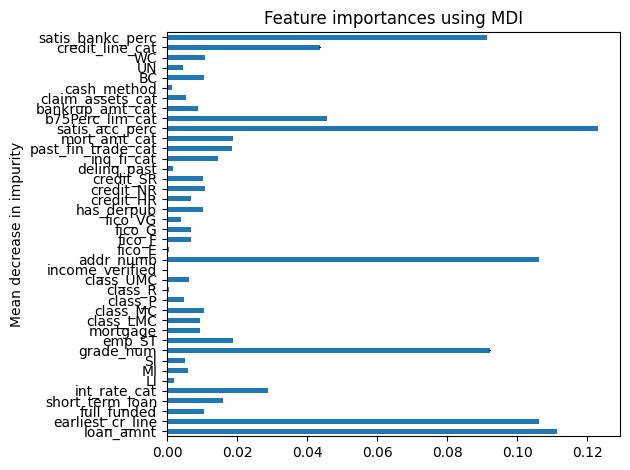

In [46]:
fpr_train, tpr_train = establishModel(data, data_labels["fully_paid"], data, data_labels["fully_paid"])

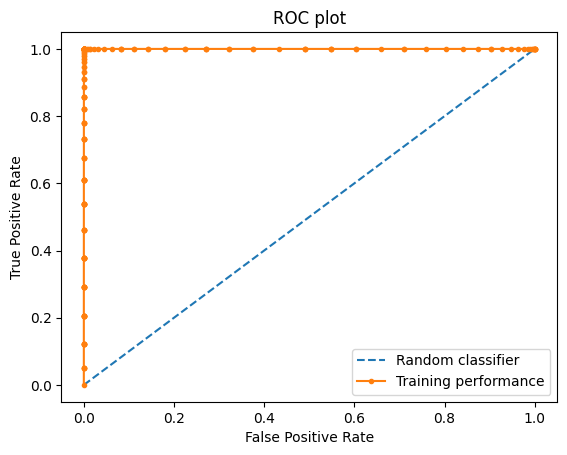

In [47]:
plt.plot([0,1], [0,1], linestyle='--', label='Random classifier')
plt.plot(fpr_train, tpr_train, marker='.', label='Training performance')
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [48]:
## Compare with test-train split
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    data_labels["fully_paid"], 
                                                    random_state=42,
                                                    stratify=data_labels["fully_paid"])

Building model...
Training model...
Calculating probabilities...
Creating prediction check df...
           True label  Probability
id                                
48866129            0         0.64
66076610            1         0.55
61451058            1         0.84
61963231            0         0.86
84769343            0         0.82
...               ...          ...
102646808           1         0.89
3353371             1         0.85
53544306            1         0.81
18855463            1         0.78
118330873           0         0.51

[313370 rows x 2 columns]
True positives: 246459
True negatives: 4779
False positives: 57500
False negatives: 4632
sensitivity/recall = 98.15525048687527%
specificity = 7.673533614862152%
precision = 81.08297500649758%
Calculating ROC...
AUC: 0.6991945546526368
Checking feature importance...


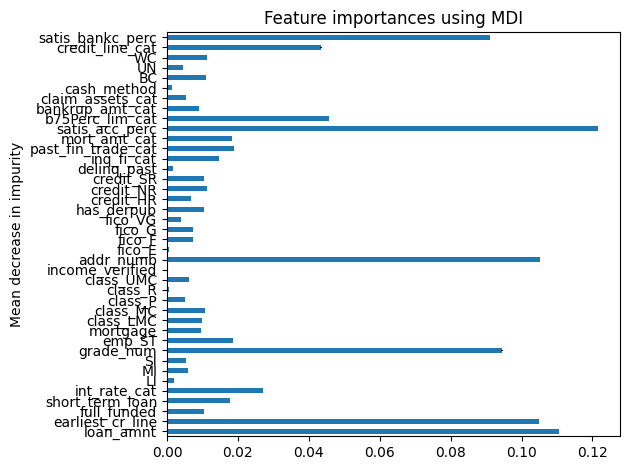

In [49]:
fpr_test, tpr_test = establishModel(X_train, y_train, X_test, y_test)

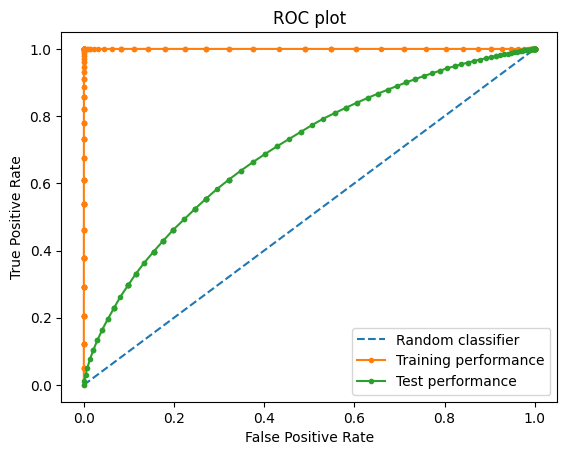

In [50]:
plt.plot([0,1], [0,1], linestyle='--', label='Random classifier')
plt.plot(fpr_train, tpr_train, marker='.', label='Training performance')
plt.plot(fpr_test, tpr_test, marker='.', label='Test performance')
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [51]:
data.drop(["satis_bankc_perc"], axis=1, inplace=True)
data.drop(["satis_acc_perc"], axis=1, inplace=True)
data.drop(["addr_numb"], axis=1, inplace=True)
data.drop(["grade_num"], axis=1, inplace=True)
data.drop(["earliest_cr_line"], axis=1, inplace=True)

Building model...
Training model...
Calculating probabilities...
Creating prediction check df...
          True label  Probability
id                               
68407277           1     1.000000
68355089           1     0.939452
68476807           1     0.893333
68426831           1     0.964451
68476668           1     0.990000
...              ...          ...
89905081           1     0.905000
88948836           1     0.830000
89996426           0     0.554833
90006534           1     0.890000
88224441           0     0.370000

[1253478 rows x 2 columns]
True positives: 994752
True negatives: 195644
False positives: 53471
False negatives: 9611
sensitivity/recall = 99.04307506349795%
specificity = 78.53561608092649%
precision = 94.89889078945988%
Calculating ROC...
AUC: 0.9805233793240204
Checking feature importance...


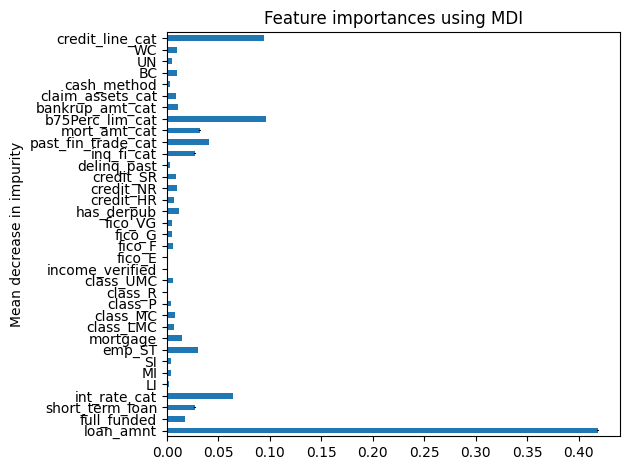

In [52]:
fpr_train, tpr_train = establishModel(data, data_labels["fully_paid"], data, data_labels["fully_paid"])

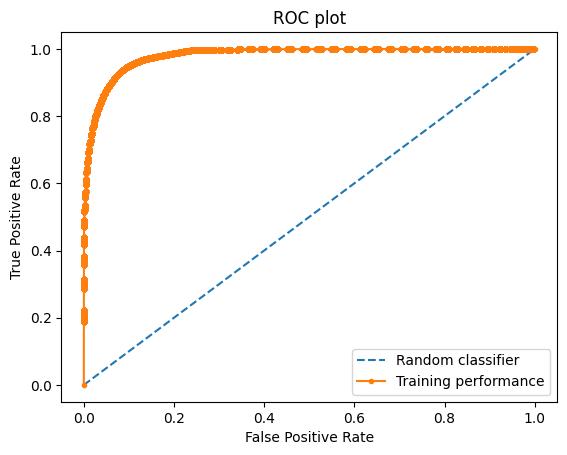

In [53]:
plt.plot([0,1], [0,1], linestyle='--', label='Random classifier')
plt.plot(fpr_train, tpr_train, marker='.', label='Training performance')
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [54]:
## Compare with test-train split
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    data_labels["fully_paid"], 
                                                    random_state=42,
                                                    stratify=data_labels["fully_paid"])

Building model...
Training model...
Calculating probabilities...
Creating prediction check df...
           True label  Probability
id                                
48866129            0     0.250167
66076610            1     0.690000
61451058            1     0.888643
61963231            0     0.880000
84769343            0     0.365000
...               ...          ...
102646808           1     0.860000
3353371             1     0.995000
53544306            1     0.870000
18855463            1     0.848571
118330873           0     0.310000

[313370 rows x 2 columns]
True positives: 230025
True negatives: 10316
False positives: 51963
False negatives: 21066
sensitivity/recall = 91.61021303033561%
specificity = 16.564170908331864%
precision = 81.5726201114941%
Calculating ROC...
AUC: 0.6341061279316796
Checking feature importance...


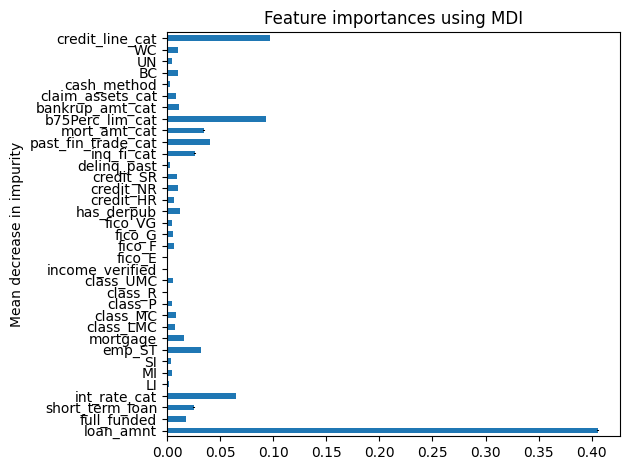

In [55]:
fpr_test, tpr_test = establishModel(X_train, y_train, X_test, y_test)

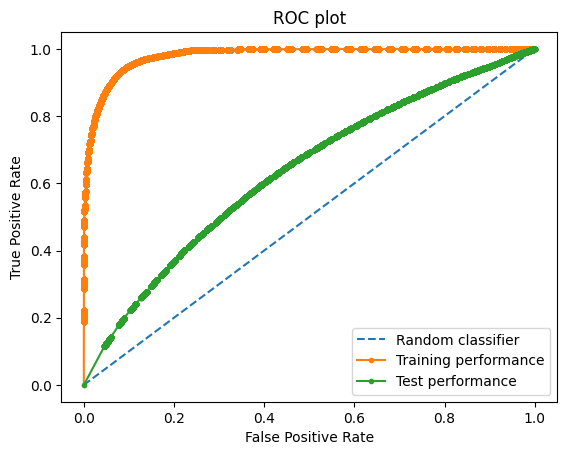

In [56]:
plt.plot([0,1], [0,1], linestyle='--', label='Random classifier')
plt.plot(fpr_train, tpr_train, marker='.', label='Training performance')
plt.plot(fpr_test, tpr_test, marker='.', label='Test performance')
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()